In [198]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)
from sklearn import metrics

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [199]:
df = pd.read_csv(r'..\Data\Panama Electricity\continuous_dataset_preprocessing.csv', parse_dates= True)
df["datetime"] = df["datetime"].apply(pd.to_datetime)

In [200]:
column_names = df.columns.tolist()
train_column_names = df.columns.tolist()
column_names.remove('datetime')
train_column_names.remove('datetime')
train_column_names.remove('nat_demand')

In [225]:
# train = df[df['datetime'] <= '1/3/2019 23:00']
# valid = train[train['datetime'] > '1/3/2018 23:00']
# train = df[df['datetime'] <= '1/3/2018 23:00']

# valid = df[df['datetime'] <= '1/3/2019 23:00']
# valid = valid[valid['datetime'] > '6/3/2018 23:00']
# train = df[df['datetime'] <= '6/3/2018 23:00']
# train = train[train['datetime'] > '1/3/2017 23:00']

valid = df[df['datetime'] <= '1/3/2019 23:00']
valid = valid[valid['datetime'] > '1/3/2018 23:00']
train = df[df['datetime'] <= '1/3/2018 23:00']

test = df[df['datetime'] > '1/3/2019 23:00']

In [226]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
trainX = x_scaler.fit_transform(train[column_names])
trainY = y_scaler.fit_transform(train[['nat_demand']])
validX = x_scaler.fit_transform(valid[column_names])
validY = y_scaler.fit_transform(valid[['nat_demand']])
# dataX = x_scaler.fit_transform(train[column_names])
# dataY = y_scaler.fit_transform(df[['nat_demand']])

In [227]:
hist_window = 24
horizon = 3

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

In [228]:
BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [205]:
lstm_multi = tf.keras.models.Sequential()
lstm_multi.add(tf.keras.layers.LSTM(150,input_shape=x_train_multi.shape[-2:],return_sequences=True))
lstm_multi.add(tf.keras.layers.Dropout(0.2))
lstm_multi.add(tf.keras.layers.LSTM(units=100,return_sequences=False))
lstm_multi.add(tf.keras.layers.Dropout(0.2))
lstm_multi.add(tf.keras.layers.Dense(units=horizon))
lstm_multi.compile(optimizer='adam', loss='mse')

In [102]:
model_path = f'..\Model\LSTM\LSTM_Multivariate_history_{hist_window}_future_{horizon}.h5'

In [103]:
EVALUATION_INTERVAL = 150
EPOCHS = 100
history = lstm_multi.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
150/150 [==============================] - 34s 195ms/step - loss: 0.0397 - val_loss: 0.0309
Epoch 2/100
150/150 [==============================] - 29s 190ms/step - loss: 0.0152 - val_loss: 0.0301
Epoch 3/100
150/150 [==============================] - 30s 202ms/step - loss: 0.0126 - val_loss: 0.0496
Epoch 4/100
150/150 [==============================] - 26s 174ms/step - loss: 0.0116 - val_loss: 0.0378
Epoch 5/100
150/150 [==============================] - 25s 164ms/step - loss: 0.0105 - val_loss: 0.0370
Epoch 6/100
150/150 [==============================] - 25s 168ms/step - loss: 0.0098 - val_loss: 0.0465
Epoch 7/100
150/150 [==============================] - 28s 190ms/step - loss: 0.0093 - val_loss: 0.0542
Epoch 7: early stopping


In [104]:
Trained_model = tf.keras.models.load_model(model_path)

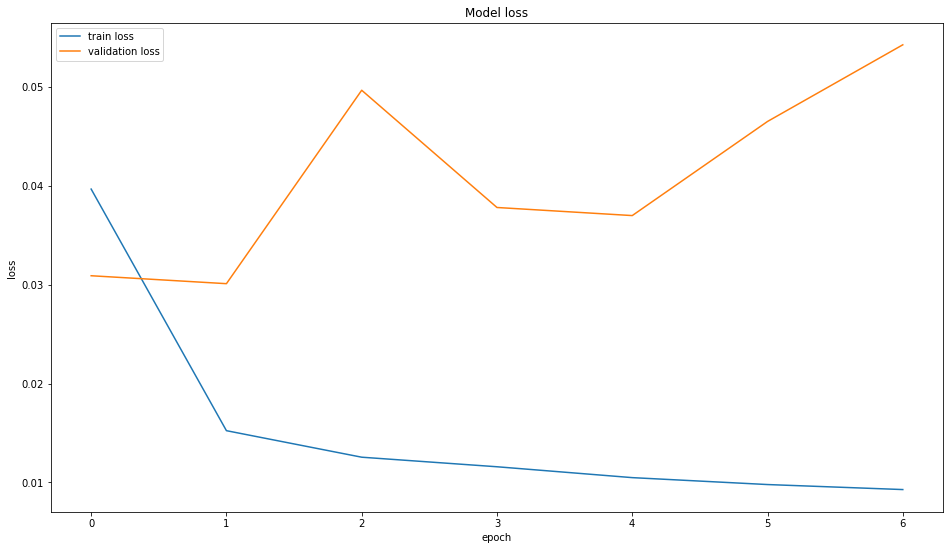

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [106]:
data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

In [107]:
Predicted_results = Trained_model.predict(test_rescaled)

1/1 [==============================] - 1s 1s/step


In [108]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [110]:
timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 9226.351780826111
MAE is : 75.37949392089843
RMSE is : 96.05390039361292
MAPE is : 6.686540781762908
R2 is : 0.7484230393807872



Epoch 1/150
100/100 [==============================] - 43s 333ms/step - loss: 0.1050 - val_loss: 0.0453
Epoch 2/150
100/100 [==============================] - 31s 311ms/step - loss: 0.0389 - val_loss: 0.0509
Epoch 3/150
100/100 [==============================] - 30s 302ms/step - loss: 0.0288 - val_loss: 0.0334
Epoch 4/150
100/100 [==============================] - 31s 309ms/step - loss: 0.0237 - val_loss: 0.0533
Epoch 5/150
100/100 [==============================] - 31s 308ms/step - loss: 0.0205 - val_loss: 0.0434
Epoch 6/150
100/100 [==============================] - 31s 312ms/step - loss: 0.0182 - val_loss: 0.0414
Epoch 7/150
100/100 [==============================] - 30s 303ms/step - loss: 0.0164 - val_loss: 0.0528
Epoch 8/150
100/100 [==============================] - 32s 317ms/step - loss: 0.0153 - val_loss: 0.0471
Epoch 9/150
100/100 [==============================] - 31s 312ms/step - loss: 0.0143 - val_loss: 0.0477
Epoch 10/150
100/100 [==============================] - 32s 320m

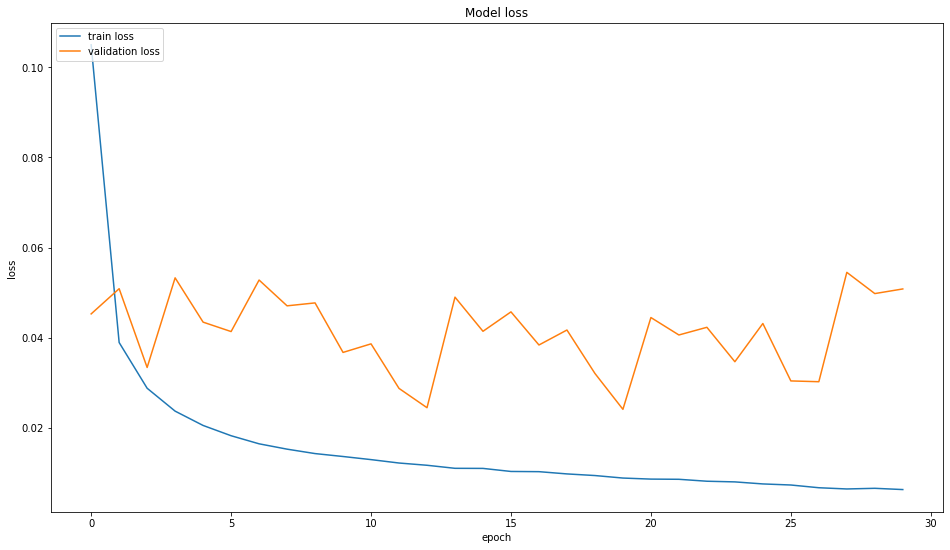

1/1 [==============================] - 2s 2s/step
Evaluation metric results:-
MSE is : 10629.878117478556
MAE is : 91.123655464681
RMSE is : 103.10130027055214
MAPE is : 7.0474017544124745
R2 is : 0.7101527784681446



In [112]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

model_path = f'..\Model\LSTM\Bidirectional_LSTM_Multivariate_history_{hist_window}_future_{horizon}.h5'

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans[0])

Epoch 1/150
100/100 [==============================] - 17s 122ms/step - loss: 0.0658 - val_loss: 0.0508
Epoch 2/150
100/100 [==============================] - 11s 109ms/step - loss: 0.0304 - val_loss: 0.0424
Epoch 3/150
100/100 [==============================] - 11s 109ms/step - loss: 0.0222 - val_loss: 0.0394
Epoch 4/150
100/100 [==============================] - 11s 110ms/step - loss: 0.0179 - val_loss: 0.0359
Epoch 5/150
100/100 [==============================] - 11s 107ms/step - loss: 0.0160 - val_loss: 0.0380
Epoch 6/150
100/100 [==============================] - 11s 108ms/step - loss: 0.0147 - val_loss: 0.0357
Epoch 7/150
100/100 [==============================] - 11s 108ms/step - loss: 0.0135 - val_loss: 0.0547
Epoch 8/150
100/100 [==============================] - 11s 106ms/step - loss: 0.0136 - val_loss: 0.0439
Epoch 9/150
100/100 [==============================] - 10s 103ms/step - loss: 0.0124 - val_loss: 0.0443
Epoch 10/150
100/100 [==============================] - 11s 110m

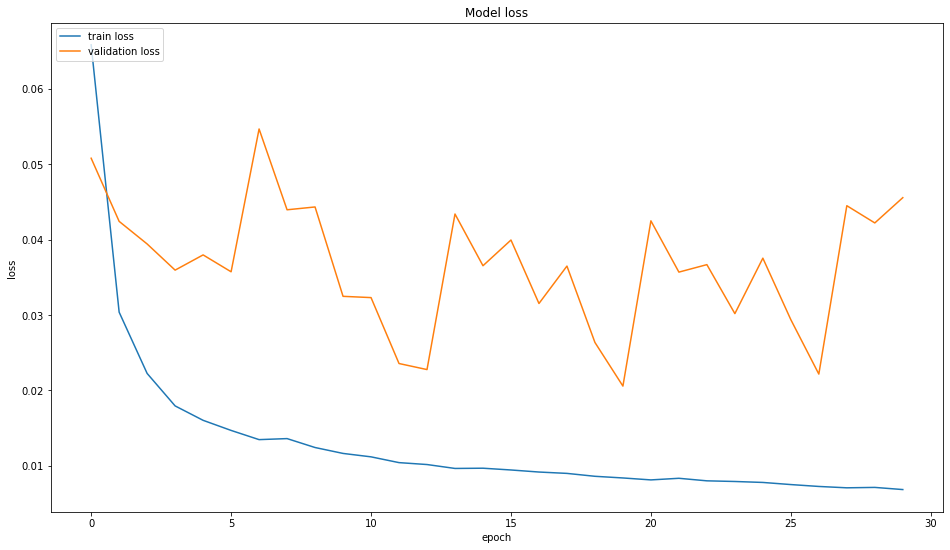

1/1 [==============================] - 1s 1s/step
Evaluation metric results:-
MSE is : 5479.951512696373
MAE is : 61.213753535970056
RMSE is : 74.02669459523621
MAPE is : 4.949327918681826
R2 is : 0.850576958406265



In [113]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')

model_path = f'..\Model\LSTM\GRU_Multivariate_history_{hist_window}_future_{horizon}.h5'

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans[0])

Epoch 1/150
100/100 [==============================] - 13s 83ms/step - loss: 0.0445 - val_loss: 0.0449
Epoch 2/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0229 - val_loss: 0.0400
Epoch 3/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0179 - val_loss: 0.0282
Epoch 4/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0150 - val_loss: 0.0253
Epoch 5/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0112 - val_loss: 0.0471
Epoch 6/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0104 - val_loss: 0.0260
Epoch 7/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0089 - val_loss: 0.0285
Epoch 8/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0085 - val_loss: 0.0307
Epoch 9/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0075 - val_loss: 0.0158
Epoch 10/150
100/100 [==============================] - 7s 73ms/step - loss: 0.00

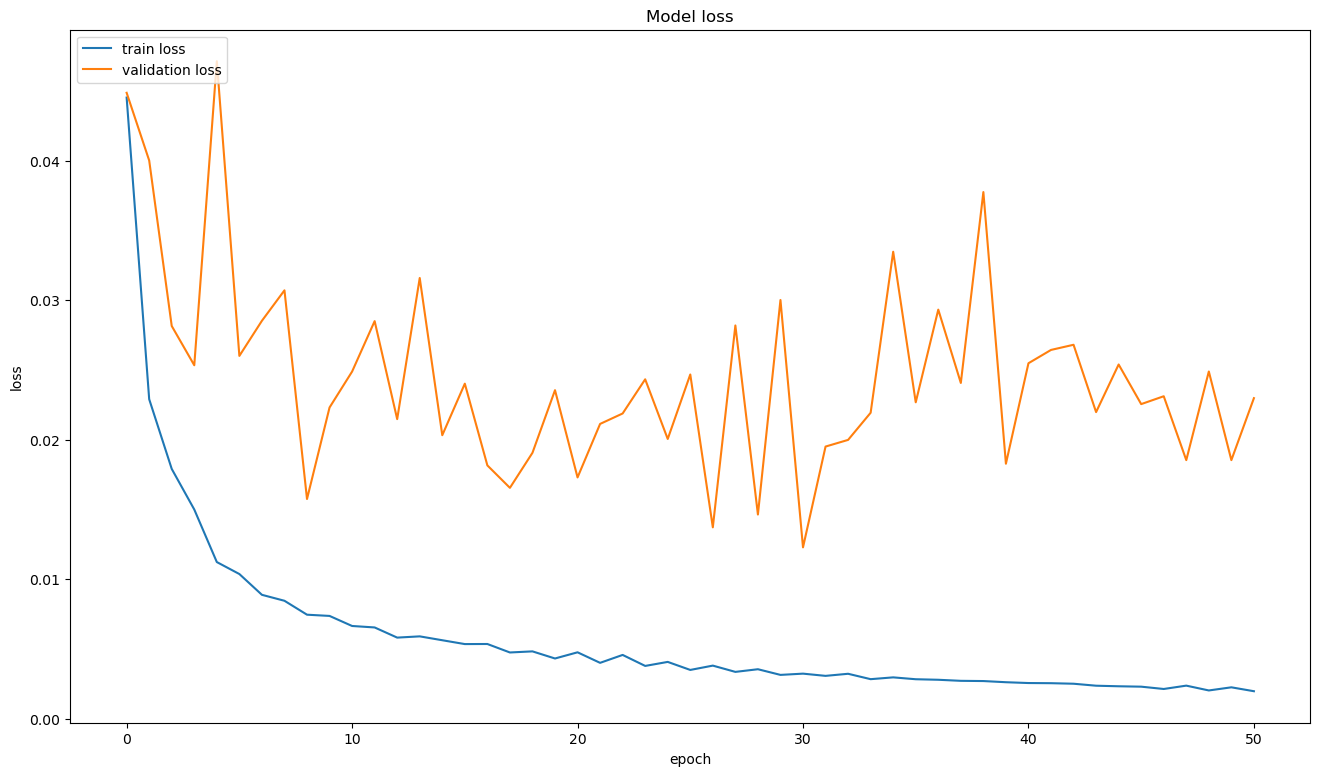

1/1 [==============================] - 1s 1s/step
Evaluation metric results:-
MSE is : 3.592026685505319
MAE is : 1.5880015625000017
RMSE is : 1.8952642785388318
MAPE is : 0.151837554937647
R2 is : 0.9957360654253028



In [235]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')

model_path = f'..\Model\LSTM\GRU_Multivariate_history_{hist_window}_future_{horizon}_3.h5'

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans[0])

In [236]:
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'..\Model\LSTM\GRU_Multivariate_history_24_future_3_3\history_loss.csv')

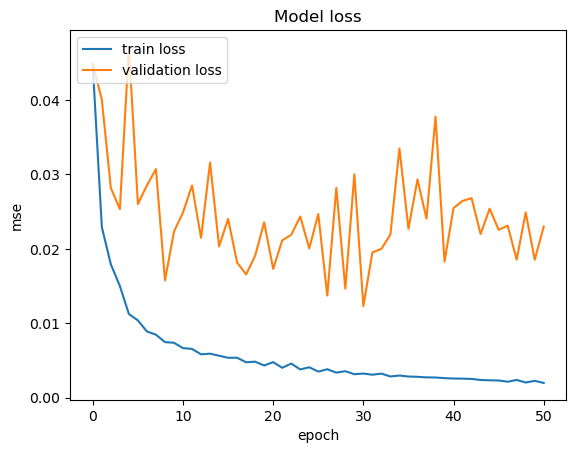

In [239]:
plt.style.use('default')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'..\Model\LSTM\GRU_Multivariate_history_24_future_3_3\history_loss_3.pdf', bbox_inches='tight')
plt.savefig(f'..\Model\LSTM\GRU_Multivariate_history_24_future_3_3\history_loss_3.svg', bbox_inches='tight')

Epoch 1/150
100/100 [==============================] - 28s 161ms/step - loss: 0.0672 - val_loss: 0.0825
Epoch 2/150
100/100 [==============================] - 13s 130ms/step - loss: 0.0279 - val_loss: 0.1016
Epoch 3/150
100/100 [==============================] - 12s 123ms/step - loss: 0.0252 - val_loss: 0.0713
Epoch 4/150
100/100 [==============================] - 13s 131ms/step - loss: 0.0247 - val_loss: 0.0958
Epoch 5/150
100/100 [==============================] - 13s 131ms/step - loss: 0.0240 - val_loss: 0.0680
Epoch 6/150
100/100 [==============================] - 13s 131ms/step - loss: 0.0238 - val_loss: 0.0634
Epoch 7/150
100/100 [==============================] - 13s 127ms/step - loss: 0.0233 - val_loss: 0.0986
Epoch 8/150
100/100 [==============================] - 13s 131ms/step - loss: 0.0243 - val_loss: 0.0809
Epoch 9/150
100/100 [==============================] - 13s 131ms/step - loss: 0.0240 - val_loss: 0.0921
Epoch 10/150
100/100 [==============================] - 13s 131m

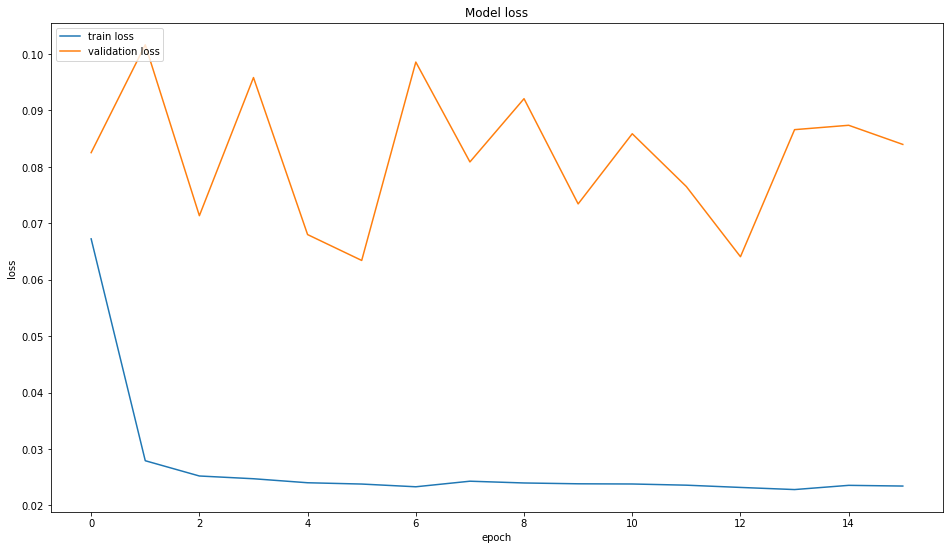

1/1 [==============================] - 3s 3s/step


ValueError: Found array with dim 3. Estimator expected <= 2.

In [129]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=20,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[1]), 
    tf.keras.layers.LSTM(units=40,return_sequences=True),
    tf.keras.layers.LSTM(units=25,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

model_path = f'..\Model\LSTM\Encoder_Decoder_LSTM_Multivariate_history_{hist_window}_future_{horizon}_2.h5'

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans)